# 들어가며

**학습목표**
- 레이어의 개념을 이해한다.
- 딥러닝 모델 속 각 레이어(Linear, Convolution)의 동작 방식을 이해한다.
- 데이터의 특성을 고려한 레이어를 설계하고, 이를 Tensorflow로 정의하는 법을 배운다.

오늘은 데이터의 차원 변화를 좇으며 각기 다른 신경망들이 갖는 Weight의 특성을 살펴보자. `Linear` layer와 `Convolution` 레이어를 집중적으로 공부하고, 이 과정을 통해 데이터의 차원 변화를 좇아 여러 신경망들이 갖는 Weight의 특성을 살펴보자.

# 1. 데이터의 형태

딥러닝을 이해하는 방법 중 가장 쉬운 방법은 데이터의 형태 변화를 좇는 것이다. 

만약 10개 단어의 문장을 
1) 5개 단어로 요약한 경우: 정보를 집약시킨 경우
2) 20개 단어로 확장한 경우: 정보를 세밀하게 표현한 경우

아래는 기업 A에 지원한 지원자들의 인적 사항이다

# `1`

데이터는 (3,6) 형태의 매트릭스로 표현이 가능하다. 만약 B 기업의 데이터가 추가된다면 어떨까?

# 2

ex. 해상도가 1280x1024(30fps)이고 러닝타임이이 90분인 흑백 영화 데이터는 어떻게 표현할까? 표기는 (T, C, H, W)를 따른다.

(162000, 1, 1024, 1280)

# 2. 레이어는 어렵다?

**레이어(layer)**는 제법 많은 곳에서 쓰이고 있다.

> 하나의 물체가 여러 개의 논리적인 객체들로 구성되어 있는 경우, 이러한 각각의 객체를 하나의 레이어라 한다. 

서론에선 신경망의 Weight라고 표현했지만, 사실 정확히는 **layer의 Weight**라는 표현이 맞다. 신경망은 레이어들이 각기 다른 Weight들과 유기적으로 연결되어 이뤄내는 결과물이다.

이제 각각의 레이어가 어떤 특징을 가지며, 어떻게 쓰이면 좋은지 알아보자.

# 3. 딥러닝의 근본! Linear 레이어

Fully Connected Layer, Feedforward Neural Network, Multilayer Perceptrons, .. 등 다양한 이름으로 불리지만 결국 Linear 레이어에 해당한다. 선형대수학에서 쓰이는 용어 중에는 Linear Transfrom이 있는데, 그것과 완전히 동일한 기능을 하는 레이어이다.

[3Blue1Brown](https://youtu.be/kYB8IZa5AuE)

Linear Layer는 선형 변환을 활용해 데이터를 특정 차원으로 변환하는 기능을 한다.

# 3

위 그림의 두 사각형 모두 (4,2) 행렬 형태의 데이터로 표현할 수 있다. 우리는 두 사각형을 하나의 정수로 표현하고자 한다.(class)

> 식1   
1단계: (4,2) x (2,1) = (4,)   
2단계: (4,) x (4,1) = (1,)

위 단계를 사용하면 각각 사각형을 정보가 집약된 하나의 정수로 표현할 수 있다. 여기서 각각의 행렬들이 Weight이다.


In [4]:
import tensorflow as tf

batch_size = 64
boxes = tf.zeros((batch_size, 4, 2))     # Tensorflow는 Batch를 기반으로 동작하기에,
                                         # 우리는 사각형 2개 세트를 batch_size개만큼
                                         # 만든 후 처리를 하게 됩니다.
print("1단계 연산 준비:", boxes.shape)

first_linear = tf.keras.layers.Dense(units=1, use_bias=False) 
# units은 출력 차원 수를 의미합니다.
# Weight 행렬 속 실수를 인간의 뇌 속 하나의 뉴런 '유닛' 취급을 하는 거죠!

first_out = first_linear(boxes)
first_out = tf.squeeze(first_out, axis=-1) # (4, 1)을 (4,)로 변환해줍니다.
                                           # (불필요한 차원 축소)

print("1단계 연산 결과:", first_out.shape)
print("1단계 Linear Layer의 Weight 값:", first_linear.weights[0])
print("1단계 Linear Layer의 Weight 형태:", first_linear.weights[0].shape)

print("\n2단계 연산 준비:", first_out.shape)

second_linear = tf.keras.layers.Dense(units=1, use_bias=False)
second_out = second_linear(first_out)
second_out = tf.squeeze(second_out, axis=-1)

print("2단계 연산 결과:", second_out.shape)
print("2단계 Linear Layer의 Weight 형태:", second_linear.weights[0].shape)

1단계 연산 준비: (64, 4, 2)
1단계 연산 결과: (64, 4)
1단계 Linear Layer의 Weight 값: <tf.Variable 'dense_6/kernel:0' shape=(2, 1) dtype=float32, numpy=
array([[1.18376   ],
       [0.27846253]], dtype=float32)>
1단계 Linear Layer의 Weight 형태: (2, 1)

2단계 연산 준비: (64, 4)
2단계 연산 결과: (64,)
2단계 Linear Layer의 Weight 형태: (4, 1)


# 4

이렇게 두 사각형에 대해 1단계를 거친 후 결과가 동일하다. 이렇게 되면 두 번째 (4x1) Weight를 거치는 게 의미가 없어진다. 여기서 모든 Weight의 요소를 **Parameter**라고 한다. 이번엔 데이터를 풍부하게 만들어보자.

> <식2>   
1단계: (4, 2) x (2 x 3) 행렬 = (4, 3)    
2단계: (4, 3) x (3 x 1) 행렬 = (4, )    
3단계: (4, ) x (4 x 1) 행렬 = (1, )    
- 총 13개의 parameter가 사용된다(2x3 + 3x1 + 4x1)

# 5

1단계를 지난 후 각 사각형에 대해 독립적인 정보가 생겨났다!! 그러면 식2는 첫 번쨰 접근에 비해 더 많은 사각형을 구분해낼 것이다! 

이를 코드로 작성해보자.

In [8]:
import tensorflow as tf

batch_size = 64
boxes = tf.zeros((batch_size, 4, 2))

print("1단계 연산 준비:", boxes.shape)

first_linear = tf.keras.layers.Dense(units=3, use_bias=False)
first_out = first_linear(boxes)

print("1단계 연산 결과:", first_out.shape)
print("1단계 Linear Layer의 Weight 형태:", first_linear.weights[0].shape)

print("\n2단계 연산 준비:", first_out.shape)

second_linear = tf.keras.layers.Dense(units=1, use_bias=False)
second_out = second_linear(first_out)
second_out = tf.squeeze(second_out, axis=-1)

print("2단계 연산 결과:", second_out.shape)
print("2단계 Linear Layer의 Weight 형태:", second_linear.weights[0].shape)

print("\n3단계 연산 준비:", second_out.shape)

third_linear = tf.keras.layers.Dense(units=1, use_bias=False)
third_out = third_linear(second_out)
third_out = tf.squeeze(third_out, axis=-1)

print("3단계 연산 결과:", third_out.shape)
print("3단계 Linear Layer의 Weight 형태:", third_linear.weights[0].shape)

total_params = \
first_linear.count_params() + \
second_linear.count_params() + \
third_linear.count_params()

print("총 Parameters:", total_params)


1단계 연산 준비: (64, 4, 2)
1단계 연산 결과: (64, 4, 3)
1단계 Linear Layer의 Weight 형태: (2, 3)

2단계 연산 준비: (64, 4, 3)
2단계 연산 결과: (64, 4)
2단계 Linear Layer의 Weight 형태: (3, 1)

3단계 연산 준비: (64, 4)
3단계 연산 결과: (64,)
3단계 Linear Layer의 Weight 형태: (4, 1)
총 Parameters: 13


파라미터가 많다고 최고일까? 그렇지 않다. 지나친 파라미터는 overfitting을 야기한다.

추가로 이야기할 것은 **편향**이다.

# 6

다음과 같이 원점을 건들지 않고는 둘을 일치시키기 어렵게 편향을 조절할 수 있다. 편향이 없다면 파라미터를 아무리 돌리고 늘려도 정확하게 근사할 수 없을 것이다. 원점을 평행이동하는 것만으로 해결되기 때문에 실제로 편향을 선형변환된 값에 편향 파라미터 b를 더해주는 것으로 표현한다.

$y = Wx + b$ 속의 $b$ 가 바로 그 편향 값이다! 앞서 공부한 예제에서 Dense classs 속 use_biad 파라미터를 True로 바꿔주면 실험해 볼 수 있다.

# 4. Convolution layer

# 7 

위와 같은 이미지를 Convolution layer를 통해 연산한다.

><식 4>   
1단계: (1920, 1080, 3) x [3 x 16 x 5 x 5 Weight & Stride 5] = (384, 216, 16)   
2단계: (384, 216, 16) → (384 x 216 x 16, )   
3단계: (1327104, ) x [1327104 x 1 Weight] = (1, )   

**16개의 5x5 필터를 가진 레이어를 정의하여 stride 5로 이미지를 훑었고,** 그렇게 생성된 출력을 **1차원으로 펼쳐 Linear layer로 정보를 집약했다**. 여기서 파라미터 수는 3x16x5x5=1200개이다. 총 파라미터 수는 약 130만 개이다. Conv 레이어는 입력 정보를 집약시키는 효과가 뛰어나기 때문에 여러 겹의 레이어를 중첩하는ㄴ 것이 일반적이고, 중첩할수록 최종 Linear 레이어는 작아지게 된다. **입력에서 중요한 부분을 뽑아내는 데에 최적화되는 것이다!**



In [10]:
import tensorflow as tf

batch_size = 64
pic = tf.zeros((batch_size, 1920, 1080, 3))

print("입력 이미지 데이터:", pic.shape)
conv_layer = tf.keras.layers.Conv2D(filters=16,
                                    kernel_size=(5, 5),
                                    strides=5,
                                    use_bias=False)
conv_out = conv_layer(pic)

print("\nConvolution 결과:", conv_out.shape)
print("Convolution Layer의 Parameter 수:", conv_layer.count_params())

flatten_out = tf.keras.layers.Flatten()(conv_out)
print("\n1차원으로 펼친 데이터:", flatten_out.shape)

linear_layer = tf.keras.layers.Dense(units=1, use_bias=False)
linear_out = linear_layer(flatten_out)

print("\nLinear 결과:", linear_out.shape)
print("Linear Layer의 Parameter 수:", linear_layer.count_params())

입력 이미지 데이터: (64, 1920, 1080, 3)

Convolution 결과: (64, 384, 216, 16)
Convolution Layer의 Parameter 수: 1200

1차원으로 펼친 데이터: (64, 1327104)

Linear 결과: (64, 1)
Linear Layer의 Parameter 수: 1327104


# 5. Pooling Layer

## Receptive Field 개념

Neural Network의 출력부가 충분한 정보를 얻기 위해 커버하는 입력 데이터의 Receptive Field가 충분히 커서 그 안에 detect 해야할 object의 특성이 충분히 포함되어 있어야 정확한 detection이 가능하게 된다.

# 8

Conv layer를 한 번 통과한 후  Output의 빨간색 포인트는 원본 이미지의 좌상단 3x3만큼의 입력만을 수용하게 된다. 그 결과 포인트의 Receptive Field의 크기는 filter size와 동일하다.

하지만 우리는 Conv lyaer 이후에는 Max pooling이 흔히 따른다는 것을 알고 있다. 아래는 Max Pooling layer가 적용된 경우를 도식화한 것이다.

# 9

## Max Pooling 레이어의 의미
이렇게 Conv layer에서 연산한 결과의 3/4를 버리는 것이다. 왜 이런 낭비를 하게 되는 것일까? 그리고 이런 정보 손실이 가져오는 Accuracy 저하 효과는 없을까?

아직 그에 대한 명확한 설명은 없지만, 다음 몇 가지 설명이 있다.

### translational invariance 효과
이미지는 약간의 상하좌우 시프트가 생긴다고 해도 내용상 동일한 특징이 있는데, Max pooiling을 통해 특징이 두드러진 영역 하나를 뽑는 것은 오히려 약간의 시프트 효과에도 불구하고 동일한 특징을 안정적으로 잡아낼 수 있는 긍정적 효과가 있어서 오히려 object 위치에 대한 오버피팅을 방지하고 안정적인 특징 추출 효과를 가져온다.

### Non-linear 함수와 동일한 피처 추출 효과
Relu와 같은 Non-linear 함수도 마찬가지로 많은 하위 레이어의 연산 결과를 무시하는 효과가 발생하지만, 그 결과로 중요한 피쳐만을 상위 레이어로 추출해 올려준다. 따라서 이는 분류기 성능을 증진시키는 효과를 갖게 된다. Min/Max Pooling도 이와 동일하다

### Receptive Field 극대화 효과
Max pooling 없이도 Receptive Field를 크게 하려면 Conv layer를 아주 많이 쌓아야 한ㄴ다. 그렇게 되면 큰 파라미터 사이즈로 인한 오버피팅, 연산량 증가 등의 문제가 발생한다.

이 문제를 효과적으로 해결하는 방법 두 가지는 Max Pooling과 Dilated Convolution이다. [상세 내용:](https://m.blog.naver.com/sogangori/220952339643)

# 6. Deconvolution layer

Conv layer를 통해 집약된 정보는 원본 데이터의 정보를 너무 많이 손실해 버린 것은 아닐까?

그래서 마지막으로 Conv의 결과를 역재생해서 원본 이미지와 유사한 정보를 복원해내는 Auto Encoder에 대해 알아보자.

MNIST 데이터셋을 입력받아 그대로 복원하는 auto encoder를 구현해보자. 순서는 다음과 같다.

- 패키지 임포트 및 MNIST 데이터셋 로딩
- AutoEncoder 모델 구성
- AutoEncoder 모델 훈련
- AutoEncoder Reconstruction Test

In [12]:
import numpy as np
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import json
import matplotlib.pyplot as plt #for plotting

# MNIST 데이터 로딩
(x_train, _), (x_test, _) = mnist.load_data()    # y_train, y_test는 사용하지 않습니다.

x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

11501568/11490434 [==============================] - 0s 0us/step


이전에 수행했던 MNIST dataset 로딩과 비슷해보이지만, **y_train, y_test를 사용하지 않는다는 점을 알 수 있다!** 왜냐하면 AutoEncoder가 수행하는 Image Reconstruction Task는 x_train의 라벨이 바로 x_train 자신이 되기 때문이다.

In [13]:
# AutoEncoder 모델 구성 - Input 부분
input_shape = x_train.shape[1:]
input_img = Input(shape=input_shape)

# AutoEncoder 모델 구성 - Encoder 부분
encode_conv_layer_1 = Conv2D(16, (3, 3), activation='relu', padding='same')
encode_pool_layer_1 = MaxPooling2D((2, 2), padding='same')
encode_conv_layer_2 = Conv2D(8, (3, 3), activation='relu', padding='same')
encode_pool_layer_2 = MaxPooling2D((2, 2), padding='same')
encode_conv_layer_3 = Conv2D(4, (3, 3), activation='relu', padding='same')
encode_pool_layer_3 = MaxPooling2D((2, 2), padding='same')

encoded = encode_conv_layer_1(input_img)
encoded = encode_pool_layer_1(encoded)
encoded = encode_conv_layer_2(encoded)
encoded = encode_pool_layer_2(encoded)
encoded = encode_conv_layer_3(encoded)
encoded = encode_pool_layer_3(encoded)

# AutoEncoder 모델 구성 - Decoder 부분
decode_conv_layer_1 = Conv2D(4, (3, 3), activation='relu', padding='same')
decode_upsample_layer_1 = UpSampling2D((2, 2))
decode_conv_layer_2 = Conv2D(8, (3, 3), activation='relu', padding='same')
decode_upsample_layer_2 = UpSampling2D((2, 2))
decode_conv_layer_3 = Conv2D(16, (3, 3), activation='relu')
decode_upsample_layer_3 = UpSampling2D((2, 2))
decode_conv_layer_4 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')

decoded = decode_conv_layer_1(encoded)   # Decoder는 Encoder의 출력을 입력으로 받습니다.
decoded = decode_upsample_layer_1(decoded)
decoded = decode_conv_layer_2(decoded)
decoded = decode_upsample_layer_2(decoded)
decoded = decode_conv_layer_3(decoded)
decoded = decode_upsample_layer_3(decoded)
decoded = decode_conv_layer_4(decoded)

# AutoEncoder 모델 정의
autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 4)           292       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 4)           0     

AutoEncoder의 구성은 Keras Model 구성 규칙을 알고 있다면 어렵지 않게 이해할 수 있다. 그리고 model.summary() 메소드를 통해 네트워크의 Output이 어떻게 변해가는지도 확인할 수 있다.

여기서 주의할 점은 Conv2D 레이어는 shape를 변화시키지 않고 있다는 점이다. Output shape를 변화시키는 것은 오롯이 MaxPooling2D 레이어의 역할이다.

Encoder를 통과한 Output은 4x4 shape가 되어 있다.

우리가 지금 보려는 것은 Decoder layer이다. `Conv2` layer와 `UpSampling2D` layer를 거쳐 28x28 사이즈의 출력이 최종적으로 나온다. 여기서도 shape는 `UpSampling2D`만 변화시킨다.

In [14]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
235/235 [==============================] - 7s 10ms/step - loss: 0.6964 - val_loss: 0.6959
Epoch 2/50
235/235 [==============================] - 2s 7ms/step - loss: 0.6955 - val_loss: 0.6950
Epoch 3/50
235/235 [==============================] - 2s 7ms/step - loss: 0.6946 - val_loss: 0.6941
Epoch 4/50
235/235 [==============================] - 2s 7ms/step - loss: 0.6936 - val_loss: 0.6931
Epoch 5/50
235/235 [==============================] - 2s 7ms/step - loss: 0.6927 - val_loss: 0.6921
Epoch 6/50
235/235 [==============================] - 2s 7ms/step - loss: 0.6916 - val_loss: 0.6911
Epoch 7/50
235/235 [==============================] - 2s 7ms/step - loss: 0.6906 - val_loss: 0.6900
Epoch 8/50
235/235 [==============================] - 2s 7ms/step - loss: 0.6894 - val_loss: 0.6888
Epoch 9/50
235/235 [==============================] - 2s 7ms/step - loss: 0.6881 - val_loss: 0.6874
Epoch 10/50
235/235 [==============================] - 2s 7ms/step - loss: 0.6867 - val_loss: 0.685

y_train이 들어갈 자리에 x_train이 들어가있다는 점을 인지하자!

그리고 주로 분류 모델에서 사용함는 `binary_crossentropy`를 사용한다는 점이 의아할 것이다. 하지만 모든 dim에서 0~1 사이의 값을 가지는 입력 데이터와 출력 데이터(마지막 출력은 simgmoid로 제어되고 있다는 점 체크) 사이의 분포가 최대한 유사하기를 바라기 때문에 이 loss를 사용한다.

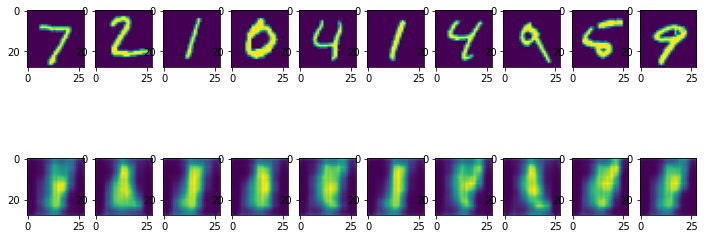

In [15]:
x_test_10 = x_test[:10]       # 테스트 데이터셋에서 10개만 골라서
x_test_hat = autoencoder.predict(x_test_10)    # AutoEncoder 모델의 이미지 복원생성
x_test_imgs = x_test_10.reshape(-1, 28, 28)
x_test_hat_imgs = x_test_hat.reshape(-1, 28, 28)

plt.figure(figsize=(12,5))  # 이미지 사이즈 지정
for i in range(10):  
    # 원본이미지 출력
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test_imgs[i])
    # 생성된 이미지 출력
    plt.subplot(2, 10, i+11)
    plt.imshow(x_test_hat_imgs[i])

훈련이 끝난 후, 실제로 우리가 만든 AutoEncoder가 MNIST 이미지를 제대로 생성하는지를 확인해보자. 결과가 썩 만족스럽지는 않다. 하지만 동일한 Decoder 네트워크 구조를 가지고도 Variational Autoencoder나 DCGAN 등은 훨씬 훌륭한 이미지를 생성하기 때문에, 이것은 Decoder 네트워크 구조만의 문제는 아닐 것이다.

### Decoder Layers for Reconstruction

Decoder에서 이미지 복원을 위해 사용한 Conv layer는 실은 Encoder에서 사용한 것과 동일한 레이어였다. 크기도 바꾸지 않고 채널 개수만 2배로 늘리고 있다. 정보를 집약하는 것이 아니라 오히려 많아지고 있다.

엄밀히 말해, 이것은 Convolution의 수학적 역연산으로서의 Deconvolution과는 다르다. 오히려 정방향의 Conv 연산을 통해 원본 이미지와 가까운 이미지를 재생해내는 효과를 구현한 것이다. 하지만 Convolution을 통해 Output shape가 줄어드는 것이 얼마든지 가능하듯, 늘어나는 것도 얼마든지 가능하다. 단지 우리의 AutoEncoder 구조가 얼마나 정보손실 없이 원본 데이터를 잘 압축하고 있느냐에 따라 Decoder가 뽑아낼 수 있는 최종적인 이미지의 퀄리티가 결정된다.

하지만 방금은 Conv layer를 활용해서 Transposse Conv를 흉내낸 것에 불과하다. Image Reconstruction을 위해서 일반적으로 많이 사용하는 Transposed Convolution을 방금 활용한 것은 아니다.

### Upsampling layer
정보를 버리는 것은 가능하지만, 이미 버린 정보를 복원하는 게 가능할까??

크게는 3가지 방법이 있다.   
- Nearest Neighbor : 복원해야 할 값을 가까운 값으로 복제한다.
- Bed of Nails : 복원해야 할 값을 0으로 처리한다.
- Max Unpooling : Max Pooling 때 버린 값을 실은 따로 기억해 두었다가 그 값으로 복원한다.

[시각적인 설명 참고](https://analysisbugs.tistory.com/104)

우리는 파라미터를 별도로 주지 않았으므로 디폴트인 Nearest Neighbor로 복원하자.

### Transposed Convolution
[Up-sampling with transposed Conv](https://zzsza.github.io/data/2018/06/25/upsampling-with-transposed-convolution/)

우린 위에서 Transposed Conv를 활용하지는 않았다. 활용을 하면 모델 구조는 아래와 같이 될 것이다.


In [16]:
from tensorflow.keras.layers import Conv2DTranspose

# Conv2DTranspose를 활용한  AutoEncoder 모델
# AutoEncoder 모델 구성 - Input 부분
input_shape = x_train.shape[1:]
input_img = Input(shape=input_shape)

# AutoEncoder 모델 구성 - Encoder 부분
encode_conv_layer_1 = Conv2D(16, (3, 3), activation='relu')
encode_pool_layer_1 = MaxPooling2D((2, 2))
encode_conv_layer_2 = Conv2D(8, (3, 3), activation='relu')
encode_pool_layer_2 = MaxPooling2D((2, 2))
encode_conv_layer_3 = Conv2D(4, (3, 3), activation='relu')

encoded = encode_conv_layer_1(input_img)
encoded = encode_pool_layer_1(encoded)
encoded = encode_conv_layer_2(encoded)
encoded = encode_pool_layer_2(encoded)
encoded = encode_conv_layer_3(encoded)

# AutoEncoder 모델 구성 - Decoder 부분  - 
decode_conv_layer_1 = Conv2DTranspose(4, (3, 3), activation='relu', padding='same')
decode_upsample_layer_1 = UpSampling2D((2, 2))
decode_conv_layer_2 = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')
decode_upsample_layer_2 = UpSampling2D((2, 2))
decode_conv_layer_3 = Conv2DTranspose(16, (3, 3), activation='relu')
decode_upsample_layer_3 = UpSampling2D((2, 2))
decode_conv_layer_4 = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')

decoded = decode_conv_layer_1(encoded)   # Decoder는 Encoder의 출력을 입력으로 받습니다.
decoded = decode_upsample_layer_1(decoded)
decoded = decode_conv_layer_2(decoded)
decoded = decode_upsample_layer_2(decoded)
decoded = decode_conv_layer_3(decoded)
decoded = decode_upsample_layer_3(decoded)
decoded = decode_conv_layer_4(decoded)

# AutoEncoder 모델 정의
autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 11, 11, 8)         1160      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 8)           0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 3, 3, 4)           292       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 3, 3, 4)           148 

In [17]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
235/235 [==============================] - 3s 8ms/step - loss: 0.6954 - val_loss: 0.6947
Epoch 2/50
235/235 [==============================] - 1s 6ms/step - loss: 0.6941 - val_loss: 0.6932
Epoch 3/50
235/235 [==============================] - 1s 6ms/step - loss: 0.6926 - val_loss: 0.6917
Epoch 4/50
235/235 [==============================] - 1s 6ms/step - loss: 0.6910 - val_loss: 0.6901
Epoch 5/50
235/235 [==============================] - 1s 6ms/step - loss: 0.6893 - val_loss: 0.6883
Epoch 6/50
235/235 [==============================] - 1s 6ms/step - loss: 0.6873 - val_loss: 0.6862
Epoch 7/50
235/235 [==============================] - 1s 6ms/step - loss: 0.6851 - val_loss: 0.6838
Epoch 8/50
235/235 [==============================] - 1s 6ms/step - loss: 0.6823 - val_loss: 0.6806
Epoch 9/50
235/235 [==============================] - 1s 6ms/step - loss: 0.6786 - val_loss: 0.6764
Epoch 10/50
235/235 [==============================] - 1s 6ms/step - loss: 0.6734 - val_loss: 0.6702

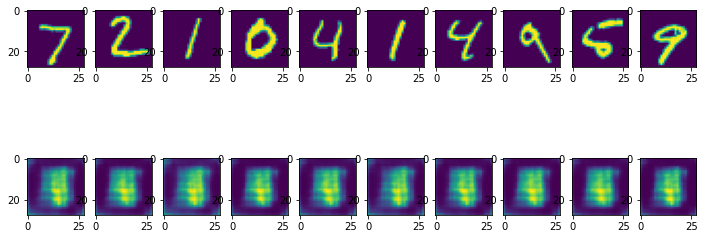

In [18]:
x_test_10 = x_test[:10]       # 테스트 데이터셋에서 10개만 골라서
x_test_hat = autoencoder.predict(x_test_10)    # AutoEncoder 모델의 이미지 복원생성
x_test_imgs = x_test_10.reshape(-1, 28, 28)
x_test_hat_imgs = x_test_hat.reshape(-1, 28, 28)

plt.figure(figsize=(12,5))  # 이미지 사이즈 지정
for i in range(10):  
    # 원본이미지 출력
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test_imgs[i])
    # 생성된 이미지 출력
    plt.subplot(2, 10, i+11)
    plt.imshow(x_test_hat_imgs[i])